In [132]:
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import fastai.vision.all as fai_vision
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

pd.options.display.max_columns = 0
matplotlib.rc('image', cmap='Greys')

In [16]:
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/daynil/mambaforge-pypy3/envs/ai-base/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [5]:
path = fai_vision.untar_data(fai_vision.URLs.MNIST)
path

Path('/home/daynil/.fastai/data/mnist_png')

In [24]:
im3 = Image.open(path/'training'/'3'/'12.png')
im3

In [72]:
def draw_tensor(tensor: torch.Tensor):
  df = pd.DataFrame(tensor)
  return df.style.set_properties(
      **{'font-size':'6pt'}
    ).background_gradient('Grays')

In [100]:
im3_t = torchvision.transforms.PILToTensor()(im3)
# draw_tensor(im3_t.squeeze()[:17, :22])
draw_tensor(im3_t.squeeze())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0,0,0,0,0,0,0,0,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0,0,0,0,0,0,0,0,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0,0,0,0,0,0,0,0,0


Kernels can effectively extract features like edge detectors from images. If we create a 3x3 kernel that is "pre-trained" for identifying horizontal edges, we'll see that horizonal edges end up with a higher activation than vertical edges.

This is because of the kernel's activations - if there is are low numbers at the top of the 3x3 image slice and a high numbers at the bottom, this is a "top edge" - we start out with low numbers, where the top part of a pen stroke is fading out, and the middle of the stroke is dark.

Likewise, if we have similar numbers at the top and bottom, we know that it is not a top edge, and the resulting activation will be lower because the top and bottom numbers will cancel out.

In [52]:
kernel = torch.tensor([[-1,-1,-1],
                       [0,0,0],
                       [1,1,1]])
kernel

tensor([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])

In [74]:
top_left_edge3 = im3_t.squeeze()[5:8, 3:6]
draw_tensor(top_left_edge3)

,0,1,2
0,12,99,91
1,138,254,254
2,220,254,254


In [82]:
right_vertical_edge3 = im3_t.squeeze()[6:9, 16:19]
draw_tensor(right_vertical_edge3)

,0,1,2
0,210,122,33
1,254,254,75
2,254,254,153


In [88]:
(top_left_edge3 * kernel).sum(), (right_vertical_edge3 * kernel).sum()

(tensor(526), tensor(296))

We can apply this kernel across every 3x3 set of pixels in the image to get a new image. This new image is a **convolution**. It is the result of applying a kernel filter to the entire image.

Since this kernel is effectively a top edge detector, areas with a top edge will be emphasized.

In [85]:
im3_t_px = im3_t.squeeze()
im3_t_px.shape

torch.Size([28, 28])

In [115]:
def convolution(im_t: torch.Tensor, kernel: torch.Tensor):
  # im3_t_px[0:3, 0:3]
  # im3_t_px[0:3, 1:4]
  # im3_t_px[0:3, 2:5]
  # ...
  # im3_t_px[1:4, 0:3]
  # im3_t_px[1:4, 1:4]
  # im3_t_px[1:4, 2:5]
  # Kernel size
  ks = kernel.shape[0]
  res = []
  for row in range(im_t.shape[0] - ks):
    res_col = []
    for col in range(im_t.shape[1] - ks):
        res_col.append(
          (im_t[row:row+ks, col:col+ks] * kernel).sum().item()
        )
    res.append(res_col)
  return torch.tensor(res).clamp(0, 255).int()

In [116]:
draw_tensor(convolution(im3_t_px, kernel))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,12,111,202,255,255,255,255,255,255,255,255,255,255,183,52,0,0,0,0,0,0,0,0,0
4,0,138,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,155,33,0,0,0,0,0,0
5,0,208,255,255,255,255,135,30,0,75,63,63,103,255,255,255,255,255,75,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,148,255,252,120,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,6,158,255,255,255,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,66,224,255,255,255,8,0,0,0,0,0,0,0,0,0,0


We can make a vertical detecting kernel similarly by flipping the kernel's values to vertical.

In [117]:
kernel_vertical = torch.tensor([[1,0,-1],
                                [1,0,-1],
                                [1,0,-1]])
draw_tensor(convolution(im3_t_px, kernel_vertical))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,91,27,0,0,24,103,131,52,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,91,27,0,0,24,105,175,182,177,122,33,0,0,0,0,0,0
5,0,0,0,0,0,0,0,19,91,27,39,0,0,40,126,182,255,255,108,0,0,0,0,0,0
6,0,0,0,0,39,29,100,71,0,0,39,0,0,0,0,100,255,255,255,0,0,0,0,0,0
7,0,0,0,0,39,29,100,71,0,0,39,0,0,0,0,0,255,255,255,0,0,0,0,0,0
8,0,0,0,0,39,10,35,25,0,0,0,0,0,0,0,182,255,255,206,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,53,0,0,0,0,0,0


We can further add a stride to a convolution, skipping that amount of pixels as we slide the kernel across the image.

This has the effect of reducing the dimensions of the image, but it maintains a course "top edge" detection. Stride is used to reduce the number of activations in an architecture as you go towards deeper layers.

In [120]:
def convolution_stride(im_t: torch.Tensor, kernel: torch.Tensor, stride: int):
  # Kernel size
  ks = kernel.shape[0]
  res = []
  for row in range(0, im_t.shape[0] - ks, stride):
    res_col = []
    for col in range(0, im_t.shape[1] - ks, stride):
        res_col.append(
          (im_t[row:row+ks, col:col+ks] * kernel).sum().item()
        )
    res.append(res_col)
  return torch.tensor(res).clamp(0, 255).int()

In [121]:
draw_tensor(convolution_stride(im3_t_px, kernel, stride=2))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,255,255,255,255,255,255,255,255,33,0,0,0
3,0,0,0,0,0,0,0,0,255,120,0,0,0
4,0,0,0,0,0,6,255,255,0,0,0,0,0
5,0,0,0,0,54,255,255,0,0,0,0,0,0
6,0,0,0,0,4,0,0,186,255,255,162,0,0
7,0,0,0,0,0,0,0,0,0,116,255,118,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,233,255,15,0,23,255,113,0,0,0


To get better resolution, we can actually return an unclamped tensor and draw it as an image where gray is the middle value (zeros), positives are black, and negatives are white.

In [128]:
def convolution_unclamped(im_t: torch.Tensor, kernel: torch.Tensor, stride=1):
  # Kernel size
  ks = kernel.shape[0]
  res = []
  for row in range(0, im_t.shape[0] - ks, stride):
    res_col = []
    for col in range(0, im_t.shape[1] - ks, stride):
        res_col.append(
          (im_t[row:row+ks, col:col+ks] * kernel).sum().item()
        )
    res.append(res_col)
  return torch.tensor(res)

<Axes: >

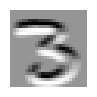

In [129]:
fai_vision.show_image(convolution_unclamped(im3_t_px, kernel))

<Axes: >

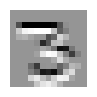

In [130]:
fai_vision.show_image(convolution_unclamped(im3_t_px, kernel, stride=2))

<Axes: >

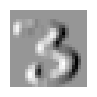

In [131]:
fai_vision.show_image(convolution_unclamped(im3_t_px, kernel_vertical))

## Using Pytorch
Pytorch allows us to apply multiple filters to batches of images simultaneously, and on the GPU. This is of course significantly faster than our manual method.

https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html

In a CNN, the weights are the kernel filters. This requires thinking of the matrix multiplication a bit differently. We don't need to have 1 activation for every pixel like in the fully connected (linear) neural networks. We just need to choose a number of kernels to apply.

Pytorch requires these to be a tensor of (out_channels, in_channels, h, w)We already have kernels of (h, w), and if we stack them, we get (2, h, w). The 2 kernels are now the out channels - they are the activations coming out of the first layer. However, we need to specify the in_channels, which is what *this* layer is ingesting from the prior layer. 

In this case, this is just the input image, which we know is black and white, so it is a single channel. For an image input layer, **a channel is one of the colors in an RGB image**, so there is a channel for red, green, and blue. Each of those is a separate array upon which a convolution is applied. But mnist is black and white, so this is just a channel of 1.

For all subsequent layers in a CNN, the in_channels is actually the amount of kernel filters we have. Since each kernel is applied to each input channel, each kernel also produces its own output channel.

In [139]:
# aka the weights 
# (out_channels, in_channels, h, w)
filters = torch.stack([kernel, kernel_vertical]).unsqueeze(1)
filters.shape

torch.Size([2, 1, 3, 3])

In [148]:
# We're simulating a minibatch of 4 by just applying the same image 4 times
# (minibatch, in_channels, h, w)
inputs = torch.stack([im3_t, im3_t, im3_t, im3_t])
inputs.shape

torch.Size([4, 1, 28, 28])

In [155]:
res_t_conv = F.conv2d(inputs.float(), filters.float(), padding=1)
res_t_conv.shape

torch.Size([4, 2, 28, 28])

What we get in return is 2 channels for each image, where each channel is each of the 2 kernels applied to the image.

The dimensions are the same because we applied a padding of 1 to the image with a 3x3 kernel.

<Axes: >

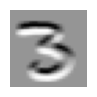

In [158]:
# Horizontal kernel filter
fai_vision.show_image(res_t_conv[0, 0])

<Axes: >

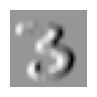

In [160]:
# Veritcal kernel filter
fai_vision.show_image(res_t_conv[0, 1])

## Convolutional Neural Networks

Ultimately our edge kernels are manually coded, so they are not useful at a large scale. In fact, as we've seen, in the later layers of deep models, the kernels become complex transformations of features from lower levels, and we can't realistically construct these manually.

So, we need to apply SGD to learn the values of the kernels automatically.

Back when we made a simple linear/fully connected layer, we created a two layer model. Since this layer is fully connected, we needed to have as many activations as pixels.

In [161]:
simple_net = torch.nn.Sequential(
  torch.nn.Linear(28*28, 30),
  torch.nn.ReLU(),
  torch.nn.Linear(30, 1)
)

However, in a CNN, we don't need to specify the number of pixels or the width/height of the image in the input layer. This is because each kernel filter is applied across every pixel automatically. 

So what we specify is just the input channels. Since we are still working with MNIST, this is 1. If we match the 30 hidden units of the linear layer, we can use 30 kernel filters, which produces 30 output channels. Then, those 30 output channels are our input channels to the next layer, after our nonlinear activation function.

However, since our ultimate goal is to classify an image, the resulting 28x28 matrix of activations is not a useful shape to us.

In [165]:
broken_cnn = torch.nn.Sequential(
  torch.nn.Conv2d(1, 30, kernel_size=3, padding=1),
  torch.nn.ReLU(),
  torch.nn.Conv2d(30, 1, kernel_size=3, padding=1)
)
broken_cnn(inputs.float()).shape

torch.Size([4, 1, 28, 28])

TODO:
- Created the correct version of this CNN by applying stride, etc to reduce the activation shape down.
- Train the cnn
- After training, see if I can somehow visualize the images with the trained weights of the first layer, then the second layer, to see how the look?